# Person identification model - Preprocessing Techniques

<span style="color:blue">
To build the embedding generator model, we utilized the raw, original datasets without applying any preprocessing or noise removal techniques. However, for a fair comparison with state-of-the-art models, we later applied each of their preprocessing methods and recorded the results. This notebook documents the process of applying those preprocessing techniques.
</span>


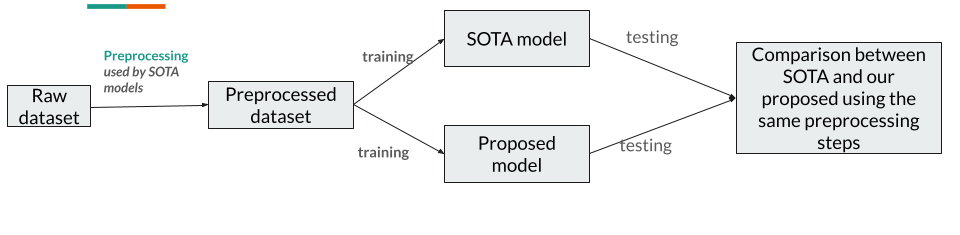

## SOTA Models and their preprocessing 

### 1. [Liu et al  ](https://ieeexplore.ieee.org/document/9638662)

* 4th-order Butterworth bandpass filter (1–40 Hz) 
* further standardized using Z-score normalization

In [1]:
def preprocessing_pipeline_model1(signal, lowcut=1.0, highcut=40.0, fs=360, order=4):

    # Step 1: Apply a 4th-order Butterworth bandpass filter
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        return lfilter(b, a, data)

    filtered_signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order)

    # Step 2: Z-score normalization
    def zscore_normalize(signal):
        mean = np.mean(signal)
        std = np.std(signal)
        return (signal - mean) / std

    normalized_signal = zscore_normalize(filtered_signal)

    return normalized_signal ,filtered_signal


### [2. Zhang et al.](https://www.sciencedirect.com/science/article/abs/pii/S0167865519302004)

* Extract features (1D Local binary pattern , shape feature , Wavelet features )
* After extracting, each feature convert into sparse representation.
* Apply collective matrix factorization on the multiple sparse representations along with label information to obtain the latent semantic space.


In [2]:
def preprocessing_pipeline_model2(signal, wavelet='db6', level=4, pre_r=60, post_r=100, sampling_rate=360):

    # Step 1: Wavelet Denoising
    def denoise_signal(signal, wavelet, level):
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        threshold = np.median(np.abs(coeffs[-level])) / 0.6745 * np.sqrt(2 * np.log(len(signal)))
        new_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
        return pywt.waverec(new_coeffs, wavelet)

    denoised_signal = denoise_signal(signal, wavelet, level)

    # Step 2: R-peak detection using Pan-Tompkins algorithm
    def detect_r_peaks(signal, sampling_rate):
        _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
        return r_peaks['ECG_R_Peaks']

    r_peaks = detect_r_peaks(denoised_signal, sampling_rate)

    # Step 3: Heartbeat segmentation
    def segment_heartbeats(signal, r_peaks, pre_r, post_r):
        heartbeats = []
        for r_peak in r_peaks:
            if r_peak - pre_r >= 0 and r_peak + post_r < len(signal):
                heartbeat = signal[r_peak - pre_r:r_peak + post_r]
                heartbeats.append(heartbeat)
        return np.array(heartbeats)

    heartbeats = segment_heartbeats(denoised_signal, r_peaks, pre_r, post_r)

    # Step 4: Normalize each heartbeat between 0 and 1
    def scale_signal(signal):
        min_val = np.min(signal)
        max_val = np.max(signal)
        return (signal - min_val) / (max_val - min_val)

    normalized_heartbeats = np.array([scale_signal(hb) for hb in heartbeats])

    # Step 5: Reconstruct the original signal by combining the normalized heartbeats
    def reconstruct_signal(normalized_heartbeats, r_peaks, pre_r, post_r, signal_length):
        reconstructed_signal = np.zeros(signal_length)
        count_overlap = np.zeros(signal_length)  # to keep track of overlaps
        
        for i, r_peak in enumerate(r_peaks):
            if r_peak - pre_r >= 0 and r_peak + post_r < signal_length:
                reconstructed_signal[r_peak - pre_r:r_peak + post_r] += normalized_heartbeats[i]
                count_overlap[r_peak - pre_r:r_peak + post_r] += 1
        
        # To avoid division by zero, set the positions without any heartbeats back to 1
        count_overlap[count_overlap == 0] = 1
        return reconstructed_signal / count_overlap

    reconstructed_signal = reconstruct_signal(normalized_heartbeats, r_peaks, pre_r, post_r, len(signal))

    return normalized_heartbeats,  reconstructed_signal

### 3.[ K. Wang et al.](https://www.sciencedirect.com/science/article/abs/pii/S0031320321005562?via%3Dihub) 

* Extract features (1D Local binary pattern , shape feature , Wavelet features,AC/DCT LBP histogram,Wavelet LBP histogram )
* After extracting, each feature convert into sparse representation.
* Apply collective non-negative matrix factorization (RMCNMF) model to handle noise and sample variation in ECG Biometrics


In [3]:
def preprocessing_pipeline_model3(signal, wavelet='db6', level=4, threshold=0.04, lowcut=5.0, highcut=15.0, sampling_rate=360, segment_length=200):
    
    # Step 1: Wavelet denoising
    def wavelet_denoise(signal, wavelet='db6', level=4, threshold=0.04):
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Apply thresholding on wavelet coefficients
        coeffs[1:] = [pywt.threshold(c, threshold * max(c)) for c in coeffs[1:]]
        return pywt.waverec(coeffs, wavelet)

    denoised_signal = wavelet_denoise(signal, wavelet, level, threshold)

    # Step 2: Pan-Tompkins algorithm for R-peak detection
    def pan_tompkins(ecg_signal, lowcut, highcut, sampling_rate):
        b, a = butter(1, [lowcut / (0.5 * sampling_rate), highcut / (0.5 * sampling_rate)], btype='band')
        filtered_signal = filtfilt(b, a, ecg_signal)

        # Derivative of the signal
        derivative = np.diff(filtered_signal)

        # Squaring the signal
        squared_signal = derivative ** 2

        # Moving window integration
        window_size = int(0.150 * sampling_rate)  # ~150ms window
        integrated_signal = np.convolve(squared_signal, np.ones(window_size) / window_size, mode='same')

        # Detect peaks
        peaks, _ = find_peaks(integrated_signal, distance=sampling_rate * 0.6)
        return peaks

    r_peaks = pan_tompkins(denoised_signal, lowcut, highcut, sampling_rate)

    # Step 3: ECG segmentation
    def segment_ecg(ecg_signal, r_peaks, segment_length):
        segments = []
        for peak in r_peaks:
            start = max(0, peak - segment_length // 2)
            end = min(len(ecg_signal), peak + segment_length // 2)
            segment = ecg_signal[start:end]
            if len(segment) == segment_length:
                segments.append(segment)
        return np.array(segments)

    segments = segment_ecg(denoised_signal, r_peaks, segment_length)

    # Step 4: Signal normalization
    def normalize_signal(signal):
        return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

    normalized_segments = np.array([normalize_signal(segment) for segment in segments])

    return normalized_segments,denoised_signal


## Dataset preparation

In [4]:
!pip install wfdb
!pip install neurokit2
import neurokit2 as nk
import wfdb
import numpy as np
import random
import os
import pywt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import butter, lfilter
from scipy.signal import resample
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score,accuracy_score, confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 13.4 MB/s eta 0:00:0000:01


In [5]:
def add_random_distortion(ecg_signal, fs=360):
    t = np.linspace(0, len(ecg_signal)/fs, len(ecg_signal), endpoint=False)
    
    def add_powerline_interference(signal):
        power_line_frequency = 60
        pli_amplitude = np.random.uniform(0.05, 0.15) * np.max(signal)
        pli_signal = pli_amplitude * np.sin(2 * np.pi * power_line_frequency * t)
        return signal + pli_signal

    def add_baseline_wander(signal):
        baseline_wander_frequency = np.random.uniform(0.1, 1)
        baseline_wander_amplitude = np.random.uniform(0.02, 0.07) * np.max(signal)
        baseline_wander = baseline_wander_amplitude * np.sin(2 * np.pi * baseline_wander_frequency * t)
        return signal + baseline_wander

    def add_gaussian_noise(signal):
        noise_amplitude = np.random.uniform(0.005, 0.02) * np.max(signal)
        noise = noise_amplitude * np.random.normal(size=len(signal))
        return signal + noise

    def add_random_spikes(signal):
        num_spikes = np.random.randint(5, 20)
        spike_amplitude = np.random.uniform(0.1, 0.3) * np.max(signal)
        spike_indices = np.random.choice(len(signal), num_spikes, replace=False)
        signal_with_spikes = np.copy(signal)
        for index in spike_indices:
            spike = spike_amplitude * (np.random.choice([-1, 1]))
            signal_with_spikes[index] += spike
        return signal_with_spikes

    def corrupt_wavelet_coefficients(signal):
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        level_to_corrupt = np.random.choice(range(1, 3))
        corruption_strength = np.random.uniform(0.05, 0.2)
        coeffs[level_to_corrupt] += corruption_strength * np.random.randn(*coeffs[level_to_corrupt].shape)
        corrupted_signal = pywt.waverec(coeffs, 'db4')
        return corrupted_signal[:len(signal)]

    distortions = [
        add_powerline_interference, 
        add_baseline_wander, 
        add_gaussian_noise, 
        add_random_spikes
    ]
    
    chosen_distortion = random.choice(distortions)
    distorted_signal = chosen_distortion(ecg_signal)
    
    
    return distorted_signal

### MIT-BIH Dataset preparation

In [6]:
# Load the Lead II ECG signal from a specified record path.
def load_lead_ii(record_path):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 0]
    return lead_ii

# Scale the ECG signal to the range [0, 1].
def scale_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

#Flatten the patient data into training, validation, and testing sets.
def flatten_patient_data(patient_data):
    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []

    for record_name, data in patient_data.items():
        train_windows = data['train']
        val_windows = data['val']
        test_windows = data['test']

        # Flatten the training, validation, and testing windows
        X_train.extend(train_windows)
        X_val.extend(val_windows)
        X_test.extend(test_windows)

        num_train_samples = len(train_windows)
        num_val_samples = len(val_windows)
        num_test_samples = len(test_windows)

        y_train.extend([record_name] * num_train_samples)
        y_val.extend([record_name] * num_val_samples)
        y_test.extend([record_name] * num_test_samples)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train).astype(int)
    y_val = np.array(y_val).astype(int)
    y_test = np.array(y_test).astype(int)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Function to extract 10-second windows from a signal
def extract_10sec_windows(signal):
    windows = []
    for i in range(0, len(signal) - 3600, 3600):  # 3600 samples correspond to 10 seconds
        window = signal[i:i + 3600]
        if len(window) == 3600:
            windows.append(window)
    return windows

In [7]:
def process_mit_bih_data(data_directory):
    patient_data = {}

    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)

            # Load Lead II data
            lead_ii = load_lead_ii(record_path)

            total_duration = len(lead_ii) // 360
            if total_duration < 30:
                raise ValueError(f"Record {record_name} is shorter than 30 minutes.")

            # Apply preprocessing to the ECG signal
            normalized_heartbeats,reconstructed_signal = preprocessing_pipeline_model1(lead_ii)

            # Calculate split points based on percentages
            train_split = int(0.60 * len(reconstructed_signal))
            val_split = int(0.80 * len(reconstructed_signal))  # 60% + 80%

            # Split into train, validation, and test segments
            train_segment = lead_ii[:train_split]
            val_segment = lead_ii[train_split:val_split]
            test_segment = lead_ii[val_split:]

            # Extract all 2-second windows for train, validation, and test sets
            train_windows = extract_10sec_windows(train_segment)
            val_windows = extract_10sec_windows(val_segment)
            test_windows = extract_10sec_windows(test_segment)

            # Normalize the windows
            scaled_train_windows = np.array([scale_signal(window) for window in train_windows])
            scaled_val_windows = np.array([scale_signal(window) for window in val_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in test_windows])

            # Store data for each record
            patient_data[record_name] = {
                'train': scaled_train_windows,
                'val': scaled_val_windows,
                'test': scaled_test_windows,
                'heartbeats': normalized_heartbeats,
            }

    return patient_data

# Example usage
data_directory = '/kaggle/input/mit-bih-mitdb/mit-bih-arrhythmia-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)

# Flatten the data for training
X_train, X_val, X_test, y_train, y_val, y_test = flatten_patient_data(patient_data)

# Reshape X_train, X_val, and X_test to match the input shape expected by the CNN
mit_X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
mit_X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
mit_X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Encode labels to integers
unique_labels = np.unique(y_train)
label_map = {label: index for index, label in enumerate(unique_labels)}
mit_y_train = np.array([label_map[label] for label in y_train])
mit_y_val = np.array([label_map[label] for label in y_val])
mit_y_test = np.array([label_map[label] for label in y_test])

num_classes = len(unique_labels)

print(f"mit_X_train shape: {mit_X_train.shape}")
print(f"mit_X_val shape: {mit_X_val.shape}")
print(f"mit_X_test shape: {mit_X_test.shape}")
print(f"mit_y_train shape: {mit_y_train.shape}")
print(f"mit_y_val shape: {mit_y_val.shape}")
print(f"mit_y_test shape: {mit_y_test.shape}")

mit_X_train shape: (5184, 3600, 1)
mit_X_val shape: (1728, 3600, 1)
mit_X_test shape: (1728, 3600, 1)
mit_y_train shape: (5184,)
mit_y_val shape: (1728,)
mit_y_test shape: (1728,)


In [8]:
def apply_distortion_to_dataset(dataset):
    distorted_dataset = np.array([add_random_distortion(signal[:, 0]) for signal in dataset])
    return distorted_dataset.reshape(distorted_dataset.shape[0], distorted_dataset.shape[1], 1)

mit_X_train_distorted = apply_distortion_to_dataset(mit_X_train)
mit_X_val_distorted = apply_distortion_to_dataset(mit_X_val)
mit_X_test_distorted = apply_distortion_to_dataset(mit_X_test)
print(f"mit_X_train_distorted shape: {mit_X_train_distorted.shape}")
print(f"mit_X_val_distorted shape: {mit_X_val_distorted.shape}")
print(f"mit_X_test_distorted shape: {mit_X_test_distorted.shape}")

mit_X_train_distorted shape: (5184, 3600, 1)
mit_X_val_distorted shape: (1728, 3600, 1)
mit_X_test_distorted shape: (1728, 3600, 1)


### PTB-DN dataset preparation

In [9]:
def load_lead_ii(record_path, target_fs=360):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 1]
    
    fs = wfdb.rdheader(record_path).fs
    if fs != target_fs:
        num_samples = int(len(lead_ii) * target_fs / fs)
        lead_ii = resample(lead_ii, num_samples)
    
    return lead_ii

In [10]:
def flatten_patient_data(patient_data):
    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []

    for record_name, data in patient_data.items():
        train_windows = data['train']
        val_windows = data['val']
        test_windows = data['test']

        # Flatten the training, validation, and testing windows
        X_train.extend(train_windows)
        X_val.extend(val_windows)
        X_test.extend(test_windows)

        num_train_samples = len(train_windows)
        num_val_samples = len(val_windows)
        num_test_samples = len(test_windows)
        
        y_train.extend([record_name] * num_train_samples)
        y_val.extend([record_name] * num_val_samples)
        y_test.extend([record_name] * num_test_samples)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
def process_ptb_dn_data(data_directory, target_fs=360, wavelet='db6', level=4, pre_r=60, post_r=100):
    patient_data = {}
    for patient in os.listdir(data_directory):
        patient_path = os.path.join(data_directory, patient)
        
        if os.path.isdir(patient_path):
            for record in os.listdir(patient_path):
                if record.endswith('.dat'):
                    record_name = os.path.splitext(record)[0]
                    record_path = os.path.join(patient_path, record_name)
                    
                    # Load and resample the signal to 360 Hz
                    lead_ii = load_lead_ii(record_path, target_fs=target_fs)

                    # Apply preprocessing to the ECG signal
                    normalized_heartbeats,reconstructed_signal = preprocessing_pipeline_model1(lead_ii)
                        
                    # Calculate split points based on percentages
                    train_split = int(0.60 * len(lead_ii))
                    val_split = int(0.80 * len(lead_ii))  # 60% + 20%

                    # Split into train, validation, and test segments
                    train_segment = lead_ii[:train_split]
                    val_segment = lead_ii[train_split:val_split]
                    test_segment = lead_ii[val_split:]

                    # Extract 10-second windows for train, validation, and test sets
                    train_windows = extract_10sec_windows(train_segment)
                    val_windows = extract_10sec_windows(val_segment)
                    test_windows = extract_10sec_windows(test_segment)
                    
                    # Normalize the windows
                    scaled_train_windows = np.array([scale_signal(window) for window in train_windows])
                    scaled_val_windows = np.array([scale_signal(window) for window in val_windows])
                    scaled_test_windows = np.array([scale_signal(window) for window in test_windows])

                    # Store data for each record
                    patient_data[record_name] = {
                        'train': scaled_train_windows,
                        'val': scaled_val_windows,
                        'test': scaled_test_windows,
                    }

    return patient_data

data_directory = '/kaggle/input/ptb-dn/ptb-diagnostic-ecg-database-1.0.0'
patient_data = process_ptb_dn_data(data_directory, target_fs=360)

X_train, X_val, X_test, y_train, y_val, y_test = flatten_patient_data(patient_data)

# Reshape X_train, X_val, and X_test to match the input shape expected by the CNN
ptbdn_X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
ptbdn_X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
ptbdn_X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

unique_labels = np.unique(y_train)
label_to_int = {label: idx + 48 for idx, label in enumerate(unique_labels)}

# Step 2: Convert the y_train, y_val, and y_test labels to integers using the same mapping
ptbdn_y_train = np.array([label_to_int[label] for label in y_train])
ptbdn_y_val = np.array([label_to_int[label] for label in y_val])
ptbdn_y_test = np.array([label_to_int[label] for label in y_test])

print(f"ptbdn_X_train shape: {ptbdn_X_train.shape}")
print(f"ptbdn_X_val shape: {ptbdn_X_val.shape}")
print(f"ptbdn_X_test shape: {ptbdn_X_test.shape}")
print(f"ptbdn_y_train shape: {ptbdn_y_train.shape}")
print(f"ptbdn_y_val shape: {ptbdn_y_val.shape}")
print(f"ptbdn_y_test shape: {ptbdn_y_test.shape}")

ptbdn_X_train shape: (3196, 3600, 1)
ptbdn_X_val shape: (987, 3600, 1)
ptbdn_X_test shape: (987, 3600, 1)
ptbdn_y_train shape: (3196,)
ptbdn_y_val shape: (987,)
ptbdn_y_test shape: (987,)


In [12]:
ptbdn_X_train_distorted = apply_distortion_to_dataset(ptbdn_X_train)
ptbdn_X_val_distorted = apply_distortion_to_dataset(ptbdn_X_val)
ptbdn_X_test_distorted = apply_distortion_to_dataset(ptbdn_X_test)

print(f"ptbdn_X_train_distorted shape: {ptbdn_X_train_distorted.shape}")
print(f"ptbdn_X_val_distorted shape: {ptbdn_X_val_distorted.shape}")
print(f"ptbdn_X_test_distorted shape: {ptbdn_X_test_distorted.shape}")

ptbdn_X_train_distorted shape: (3196, 3600, 1)
ptbdn_X_val_distorted shape: (987, 3600, 1)
ptbdn_X_test_distorted shape: (987, 3600, 1)


## Model Development

In [13]:
def create_CNN_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(256, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(512, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(512, activation=None, 
                     kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
        layers.Dropout(0.2),  # Dropout layer
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  
    ])
    return model

input_shape = (X_train.shape[1], 1)
cnn_model = create_CNN_model(input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
def contrastive_loss(y_true, y_pred, margin=2.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [15]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


In [16]:
def create_siamese_network(input_shape):
    input_A = layers.Input(shape=input_shape)
    input_B = layers.Input(shape=input_shape)
    
    embeddings_A = cnn_model(input_A)
    embeddings_B = cnn_model(input_B)
    
    # Compute the Euclidean distance between the embeddings
    distance = layers.Lambda(euclidean_distance)([embeddings_A, embeddings_B])
    
    siamese_network = models.Model(inputs=[input_A, input_B], outputs=distance)
    return siamese_network

siamese_network = create_siamese_network(input_shape)
siamese_network.compile(loss=contrastive_loss, optimizer='adam')

In [17]:
def create_pairs(X, y):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))
    indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    for idx1 in range(len(X)):
        idx2 = random.choice(indices[y[idx1]])
        pairs.append([X[idx1], X[idx2]])
        labels.append(1)
        
        # Select a random negative example
        neg_idx = np.random.choice(np.where(y != y[idx1])[0])
        pairs.append([X[idx1], X[neg_idx]])
        labels.append(0)
        
        if random.random() < 0.00001:  # 10% chance to plot
            plt.title("anchor")
            plt.plot(X[idx1].reshape(-1)[:])
            plt.show()
            
            plt.title("postive")
            plt.plot(X[idx2].reshape(-1)[:])
            plt.show()
            
            plt.title('negative')
            plt.plot(X[neg_idx].reshape(-1)[:])
            plt.show()

    return np.array(pairs), np.array(labels)

# Create pairs for training and testing
pairs_train, labels_train = create_pairs(mit_X_train_distorted, mit_y_train)
pairs_test, labels_test = create_pairs(mit_X_val_distorted, mit_y_val)
labels_train=labels_train.astype(int)
labels_test=labels_test.astype(int)

### Training 

In [18]:
# Train the Siamese network
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    batch_size=32,
    epochs=50
)

Epoch 1/50


I0000 00:00:1729250333.486054     115 service.cc:145] XLA service 0x7888e0003690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729250333.486108     115 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729250333.486120     115 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/324 ━━━━━━━━━━━━━━━━━━━━ 46:08 9s/step - loss: 6.4017

I0000 00:00:1729250340.020963     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - loss: 2.2144 - val_loss: 0.8820
Epoch 2/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - loss: 0.8425 - val_loss: 0.7216
Epoch 3/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - loss: 0.7814 - val_loss: 0.6702
Epoch 4/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - loss: 0.7161 - val_loss: 0.5671
Epoch 5/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - loss: 0.6383 - val_loss: 0.4837
Epoch 6/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 0.5994 - val_loss: 0.4788
Epoch 7/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 0.5672 - val_loss: 0.4661
Epoch 8/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - loss: 0.5511 - val_loss: 0.4346
Epoch 9/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - loss: 0.5508 - val_loss: 0.4302
Epoch 10/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 0.5304 - val_loss: 0.4077
Epoch 11/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 0.5376 - val_loss: 0.4200
Epoch 12/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 

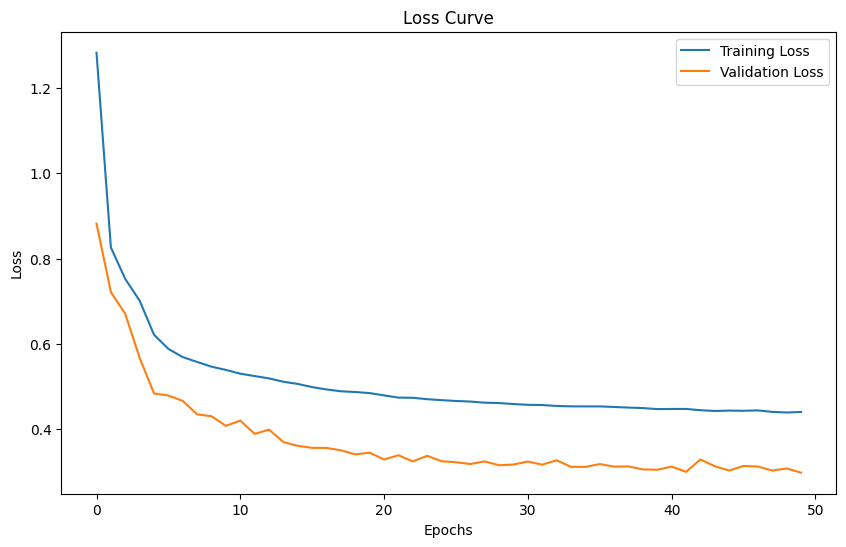

In [19]:
import matplotlib.pyplot as plt

def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')

    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss')

    # Adding title and labels
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve(history)

## Identification

### 1. KNN

In [25]:
# Step 2: Implement a custom kNN algorithm
def custom_knn(embeddings_train, labels_train, embeddings_test, k=5):
    predictions = []
    
    for test_embedding in embeddings_test:
        # Calculate the Euclidean distance between the test embedding and all train embeddings
        distances = np.linalg.norm(embeddings_train - test_embedding, axis=1)
        
        # Get the indices of the k-nearest neighbors
        knn_indices = np.argsort(distances)[:k]
        
        # Get the labels of the k-nearest neighbors
        knn_labels = labels_train[knn_indices]
        
        # Determine the most common label among the k-nearest neighbors
        unique_labels, counts = np.unique(knn_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        
        predictions.append(predicted_label)
    
    return np.array(predictions)


In [ ]:
def generate_embeddings(model, X):
    embeddings = model.predict(X)
    return embeddings

embeddings_test = generate_embeddings(cnn_model, mit_X_test)
embeddings_train = generate_embeddings(cnn_model, mit_X_val)

predicted_labels = custom_knn(embeddings_train, mit_y_val, embeddings_test, k=10)

precision = precision_score(mit_y_test, predicted_labels, average='macro')
recall = recall_score(mit_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(mit_y_test, predicted_labels)
accuracy = accuracy_score(mit_y_test, predicted_labels)

# Print the results
print("----MIT-BIH- KNN-----")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
embeddings_test = generate_embeddings(cnn_model, ptbdn_X_test)
embeddings_train = generate_embeddings(cnn_model, ptbdn_X_train)

predicted_labels = custom_knn(embeddings_train, ptbdn_y_train, embeddings_test, k=5)

precision = precision_score(ptbdn_y_test, predicted_labels, average='macro')
recall = recall_score(ptbdn_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptbdn_y_test, predicted_labels)
accuracy = accuracy_score(ptbdn_y_test, predicted_labels)

print("----- PTB-DN KNN ---------")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Confusion Matrix:\n", conf_matrix)

### 2. XGBoost

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(embeddings_train, mit_y_val, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

predicted_labels = xgb_model.predict(embeddings_test)

precision = precision_score(mit_y_test, predicted_labels, average='macro')
recall = recall_score(mit_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(mit_y_test, predicted_labels)
accuracy = accuracy_score(mit_y_test, predicted_labels)

print("--MIT-BIH XGBoost--")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(embeddings_train, ptbdn_y_val, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

predicted_labels = xgb_model.predict(embeddings_test)

precision = precision_score(mit_y_test, predicted_labels, average='macro')
recall = recall_score(mit_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(mit_y_test, predicted_labels)
accuracy = accuracy_score(mit_y_test, predicted_labels)

print("--- PTB-DN XGBoost----")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Confusion Matrix:\n", conf_matrix)

### 3. Neural network

In [23]:
X_train, X_val, y_train, y_val = train_test_split(embeddings_train, mit_y_val, test_size=0.2, random_state=42)

# Build a simple feedforward neural network
def create_nn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define input shape and number of classes
input_shape = embeddings_train.shape[1]  # Number of features
num_classes = len(np.unique(mit_y_val))    # Number of unique labels

# Create and train the neural network model
nn_model = create_nn_model((input_shape,), num_classes)
nn_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val),verbose = 0)

predicted_labels = np.argmax(nn_model.predict(embeddings_test), axis=-1)

precision = precision_score(mit_y_test, predicted_labels, average='macro')
recall = recall_score(mit_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(mit_y_test, predicted_labels)
conf_matrix = confusion_matrix(mit_y_test, predicted_labels)

print("---MIT-BIH neural network----")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision: 92.39%
Recall: 90.68%
Accuracy: 90.68%
Confusion Matrix:
 [[35  0  0 ...  0  0  0]
 [ 0 36  0 ...  0  0  0]
 [ 0  0 36 ...  0  0  0]
 ...
 [ 0  0  0 ... 36  0  0]
 [ 0  0  0 ...  0 35  0]
 [ 0  0  0 ...  0  0 36]]
